In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import time
from scipy import signal
import warnings
from sklearn.preprocessing import minmax_scale
import heartpy as hp
warnings.filterwarnings('ignore')
# if 'ParaFolder' not in locals():
#     print('ParaFolder No exist')

In [2]:
source_dir = 'D:/Code/data/PLETH/'

rawdata_list = os.listdir(source_dir)
print(len(rawdata_list))

6157


In [3]:
Censoring    = 100 * 60 * 25  # 25 min, 데이터에서 앞의 25분과 뒤의 25분을 잘라내기 위한 상수값(hyper parameter)
DataSet      = []
ErrorTracker = []
SampleInfo   = []
RawSampleIDXList = []

path = 'D:/Code/data/'
ParaFolder = 'ValPLETH'

In [11]:
for idx, filename in enumerate(rawdata_list[4000:]):
    print(idx, ': ', filename)
    data = np.load(source_dir + filename, allow_pickle=True)['PLETH'][:,0][Censoring:-Censoring]

    # 0보다 작거나 100보다 크고, Nan 값 있는 index 선택,
    ExcCriteria = np.where( (data<0) | (data>100) | np.isnan(data))[0]
    ExcCriteria = np.concatenate([[0], ExcCriteria, [data.shape[0]]])
    IndMaxDif = ExcCriteria[1:] - ExcCriteria[:-1]
    IndMaxDif_enough = np.where(IndMaxDif>100*60*1)[0] # 1 분이상 연속시계열 확보 구간 선정

    if len(IndMaxDif_enough) <= 0: # OBS 확보 안되는 sample은 포함 시키지 않기
        print('Sample excluded due to small obs.')
        ErrorTracker.append(str(idx)+' excluded due to small obs.')
        print()
        continue

    StartInd = ExcCriteria[IndMaxDif_enough][..., np.newaxis]
    EndInd = ExcCriteria[IndMaxDif_enough+1][..., np.newaxis]
    SelectedPeriod = np.concatenate([StartInd,EndInd], axis=-1)

    SampleIDXVec = np.full((SelectedPeriod.shape[0],1), idx)
    RawSampleIDX = np.concatenate([SampleIDXVec, (SelectedPeriod + Censoring)], axis=1)
    RawSampleIDXList.append(RawSampleIDX)

    for PeriodNum,Period in enumerate(SelectedPeriod):
        print('Sample-'+str(idx)+'-'+str(PeriodNum))
        SampleInfo.append('Sample-'+str(idx)+'-'+str(PeriodNum))
        DataSet.append(data[Period[0]:Period[1]])
    print()


0 :  4736.npz
Sample-0-0
Sample-0-1

1 :  4737.npz
Sample-1-0

2 :  4738.npz
Sample-2-0
Sample-2-1

3 :  4739.npz
Sample-3-0
Sample-3-1
Sample-3-2

4 :  4740.npz
Sample-4-0
Sample-4-1
Sample-4-2

5 :  4741.npz
Sample-5-0
Sample-5-1
Sample-5-2

6 :  4742.npz
Sample-6-0
Sample-6-1
Sample-6-2
Sample-6-3
Sample-6-4
Sample-6-5
Sample-6-6
Sample-6-7
Sample-6-8
Sample-6-9
Sample-6-10
Sample-6-11
Sample-6-12
Sample-6-13

7 :  4743.npz
Sample-7-0
Sample-7-1
Sample-7-2
Sample-7-3
Sample-7-4
Sample-7-5
Sample-7-6

8 :  4744.npz
Sample-8-0
Sample-8-1
Sample-8-2
Sample-8-3
Sample-8-4
Sample-8-5

9 :  4745.npz
Sample-9-0
Sample-9-1
Sample-9-2
Sample-9-3

10 :  4746.npz
Sample-10-0
Sample-10-1
Sample-10-2

11 :  4747.npz
Sample-11-0

12 :  4748.npz
Sample-12-0
Sample-12-1
Sample-12-2
Sample-12-3
Sample-12-4
Sample-12-5
Sample-12-6

13 :  4749.npz
Sample-13-0
Sample-13-1
Sample-13-2
Sample-13-3
Sample-13-4
Sample-13-5
Sample-13-6
Sample-13-7
Sample-13-8
Sample-13-9
Sample-13-10
Sample-13-11
Sample-13-

In [12]:
np.save(path+ParaFolder+'/DataSet3', DataSet)

In [26]:
DataSet = np.load(path+ParaFolder+'/DataSet3.npy', allow_pickle = True)
len(DataSet)

11425

In [17]:
def get_difference_list(seq):
    seq  = np.concatenate([[0], seq, [0]])
    differ = seq[1:] - seq[:-1]
    differ = differ[1:-1]
    return differ

In [18]:
def check_ppg(ppg, sig_length=6000, fs=100):
    PPG = minmax_scale(ppg)
    # Transpose the Signals if they are in column format, necessary for peak detection
    if PPG.shape[0] > 1:
        PPG = PPG.T

    try:
        wd_p, _ = hp.process(PPG, sample_rate=fs) # peak 검출
    except Exception:
        return 0

    # Peak
    pks_PPG = wd_p['peaklist'] # peak의 위치 리스트
    pks_PPG = np.array(pks_PPG)
    peak_dist_PPG = get_difference_list(pks_PPG) # peak 간격 리스트
    std_peak_dist_PPG = np.std(peak_dist_PPG) # peak 간격의 std, feature 1
    std_peaks_PPG = np.std(PPG[pks_PPG]) # peak 값의 std, feature 2
    num_peaks_PPG = len(pks_PPG) # peak 갯수, feature 3

    # peak 값들이 고르지 않거나, peak 간격이 고르지 않거나, peak 갯수가 길이에 비해 많거나 적을 경우 => bad signal
    if (std_peaks_PPG > 0.08) or (std_peak_dist_PPG > 10) or (num_peaks_PPG < int(sig_length/(fs*1.5))) or (num_peaks_PPG > int(sig_length/(fs*0.5))):
        return 0

    # 첫번째 peak가 너무 늦게 검출되거나, 마지막 peak가 너무 이르게 검출되면 => bad signal
    if (pks_PPG[0] > 1.5*np.mean(peak_dist_PPG)) or (sig_length - pks_PPG[-1] > 1.5*np.mean(peak_dist_PPG)):
        return 0

    # 추가 feature
    max_min_differ_pks = np.max(PPG[pks_PPG]) - np.min(PPG[pks_PPG]) # 최대 peak와 최소 peak 차이, feature 4
    differ_pks = get_difference_list(PPG[pks_PPG])
    max_differ_pks = max(np.abs(differ_pks)) # peak간 차분값의 최댓값, feature 5

    if (max_min_differ_pks > 0.19) or (max_differ_pks > 0.15):
        return 0

    # Valley
    P2PIDX =  np.concatenate([pks_PPG[:-1][..., np.newaxis], pks_PPG[1:][..., np.newaxis] ], axis=-1)
    val_PPG =  np.unique([np.argmin(PPG[i[0]:i[1]]) +i[0]  for i in P2PIDX])

    valley_dist_PPG = get_difference_list(val_PPG) # valley 간격 리스트
    std_valley_dist_PPG = np.std(valley_dist_PPG) # valley 간격의 std
    std_valley_PPG = np.std(PPG[val_PPG]) # valley 값의 std
    num_valley_PPG = len(val_PPG) # valley 갯수

    # 첫값이 매우 작으면 bad signal
    if ppg[0] < (np.min(ppg[val_PPG])-5):
        return 0

    # valley 값들이 고르지 않거나, valley 간격이 고르지 않거나, valley 갯수가 길이에 비해 많거나 적을 경우 => bad signal
    if (std_valley_PPG > 0.08) or (std_valley_dist_PPG > 18) or (num_valley_PPG < int(sig_length/(fs*1.5))) or (num_valley_PPG > int(sig_length/(fs*0.5))):
        return 0

    # 첫번째 valley가 너무 늦게 검출되거나, 마지막 valley가 너무 이르게 검출되면 => bad signal
    if (val_PPG[0] > 1.5*np.mean(valley_dist_PPG)) or (sig_length - val_PPG[-1] > 1.5*np.mean(valley_dist_PPG)):
        return 0

    # 추가 feature
    max_min_differ_val = np.max(PPG[val_PPG]) - np.min(PPG[val_PPG]) # 최대 valley와 최소 valley 차이, feature 4
    differ_val = get_difference_list(PPG[val_PPG])
    max_differ_val = max(np.abs(differ_val)) # valley간 차분값의 최댓값, feature 5

    if (max_min_differ_val > 0.19) or (max_differ_val > 0.15):
        return 0

    # 고주파 signal 제외
    GradSignal = np.gradient(PPG)
    NegGradIDX = np.where(GradSignal<0)[0]
    NegGradIDX = np.delete(NegGradIDX,np.where(NegGradIDX==0)) # idx 0의 경우 제외
    gradient_convert = NegGradIDX[GradSignal[NegGradIDX-1]>=0]

    if len(gradient_convert)>=700:
        return 0

    return 1

In [27]:
print(f'check {len(DataSet)} files')

CleanSet = []

for idx, data in enumerate(DataSet):   # range(len(rawdata_list)):
    print(f'checking {idx}th file')
    normal_ppg_list = list()

    L = data.shape[0]

    for i in range(0, ((L//6000)-1)):
        Sample60 = data[i*6000: (i+1)*6000]
        if check_ppg(Sample60):
            CleanSet.append(Sample60)

print('complete')
print(len(CleanSet))

check 11425 files
checking 0th file
checking 1th file
checking 2th file
checking 3th file
checking 4th file
checking 5th file
checking 6th file
checking 7th file
checking 8th file
checking 9th file
checking 10th file
checking 11th file
checking 12th file
checking 13th file
checking 14th file
checking 15th file
checking 16th file
checking 17th file
checking 18th file
checking 19th file
checking 20th file
checking 21th file
checking 22th file
checking 23th file
checking 24th file
checking 25th file
checking 26th file
checking 27th file
checking 28th file
checking 29th file
checking 30th file
checking 31th file
checking 32th file
checking 33th file
checking 34th file
checking 35th file
checking 36th file
checking 37th file
checking 38th file
checking 39th file
checking 40th file
checking 41th file
checking 42th file
checking 43th file
checking 44th file
checking 45th file
checking 46th file
checking 47th file
checking 48th file
checking 49th file
checking 50th file
checking 51th file
chec

In [28]:
np.save(path+ParaFolder+'/CleanSet3', CleanSet)

In [4]:
CleanDataSet = np.load(path+ParaFolder+'/CleanSet3.npy',allow_pickle = True)
len(CleanDataSet)

27409

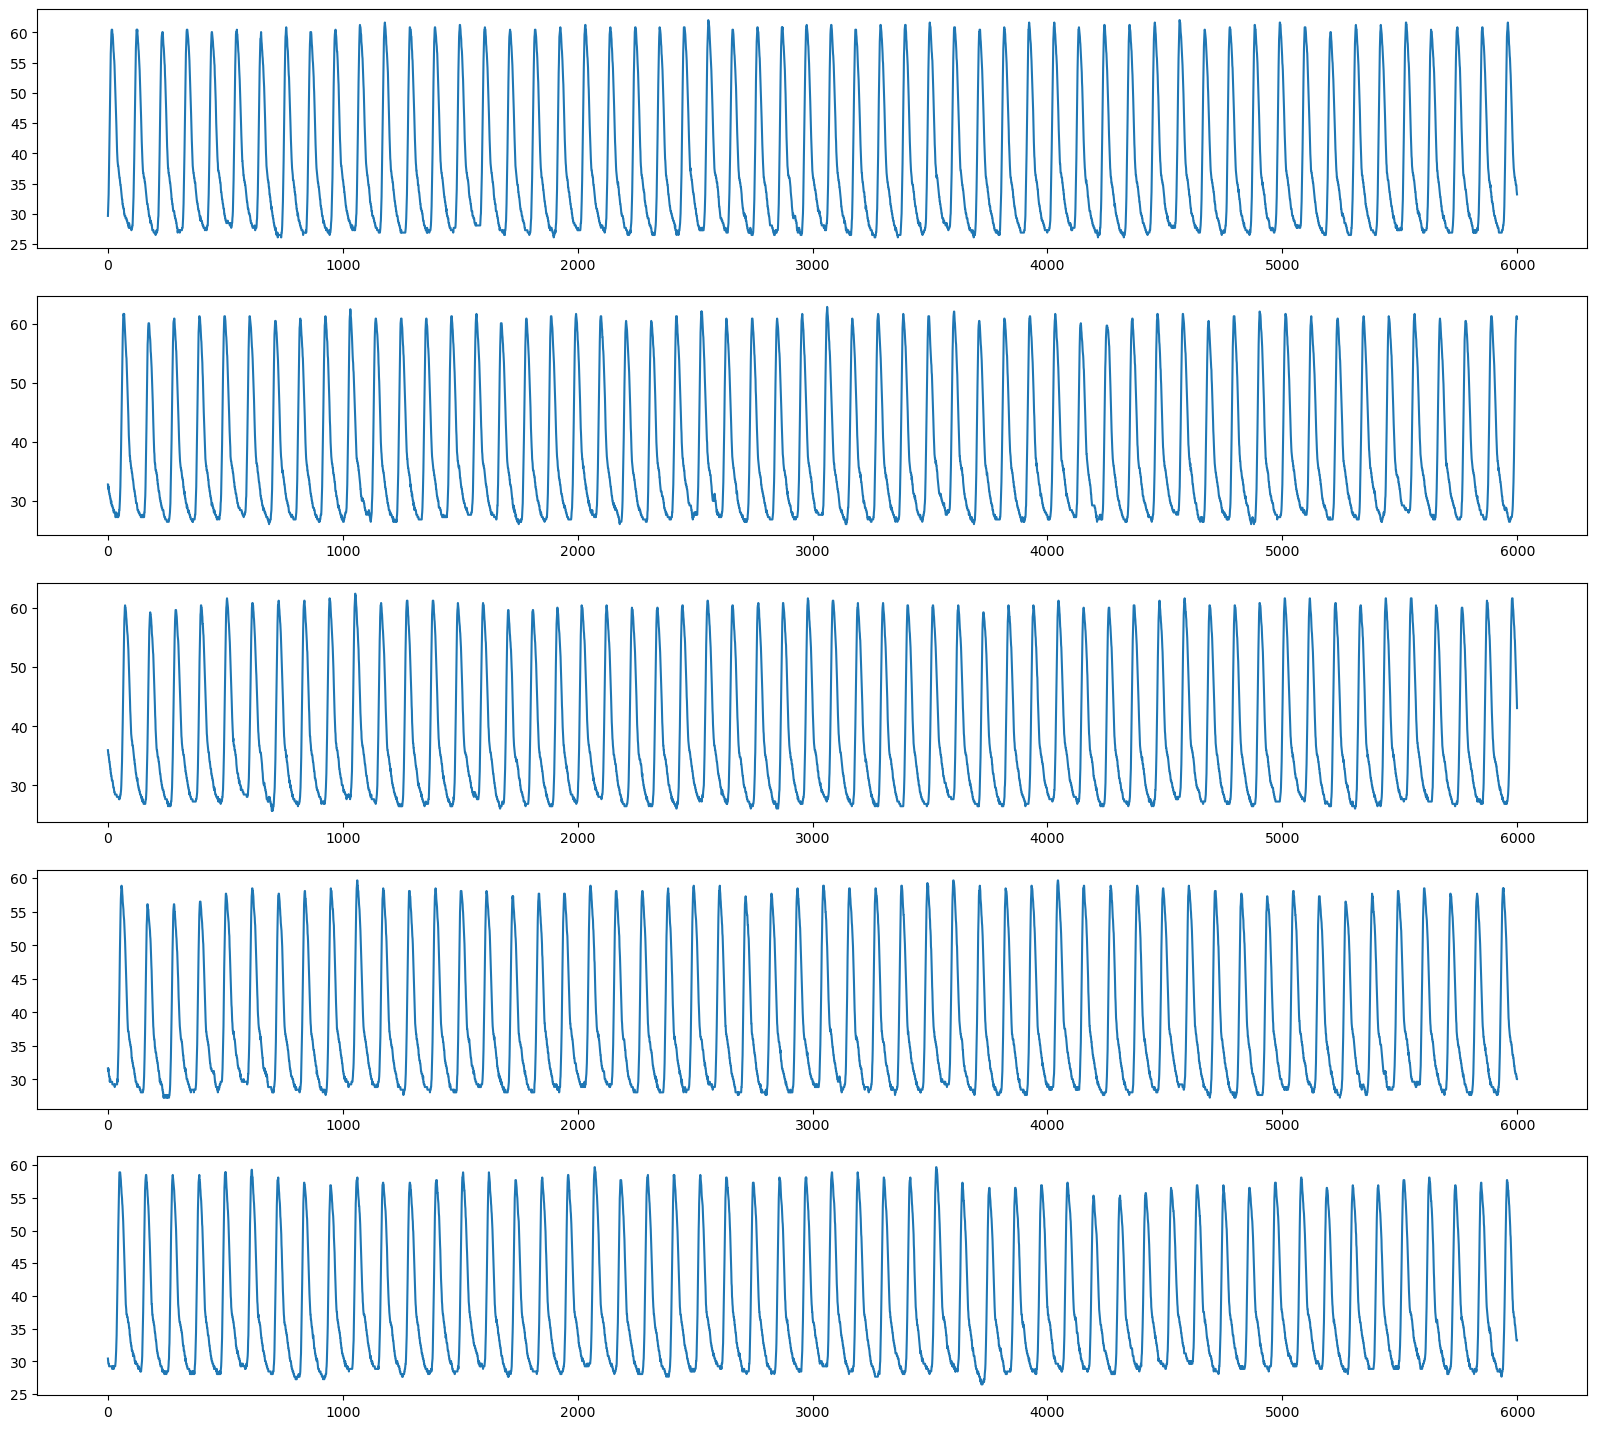

In [6]:
DataID = 122

plt.figure(figsize=(20,18))

plt.subplot(511)
plt.plot(CleanDataSet[DataID])

plt.subplot(512)
plt.plot(CleanDataSet[DataID+1])

plt.subplot(513)
plt.plot(CleanDataSet[DataID+2])

plt.subplot(514)
plt.plot(CleanDataSet[DataID+3])

plt.subplot(515)
plt.plot(CleanDataSet[DataID+4])

plt.show()